# Model Exploration #
In the notebook `Model Training.ipynb` I trained a language model over English pronunciations from [the CMU Pronouncing Dictionary](http://www.speech.cs.cmu.edu/cgi-bin/cmudict). CMU Dict contains phonetic representations of about 132,000 words, so the goal of the language model is to learn what sequences of sounds constitute good words.

In this notebook I use the model to:
1. **Identify which English pronunciations are most- and least-Englishlike**. For example, I would expect "fun" to sound normal and a borrowed word like "cliché" to be less normal.
2. **Generate novel words** that aren't English words but sound like they could be.

I'll also dig into what the model has learned to see whether it has learned the [phonotactics rules](https://en.wikipedia.org/wiki/Phonotactics) that all English speakers subconsciously understand.

Note that the pronunciations are in [IPA](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet).

In [1]:
import numpy as np

import pandas as pd
import torch
from matplotlib import pyplot as plt

from sonorant.analysis_utils import analogy, most_similar_phonemes, plot_next_phoneme_distribution, plot_pronunciation_probability
from sonorant.languagemodel import LanguageModel
from sonorant.utils import perplexity
from sonorant.pronunciationdata import augment_pronunciations_df, load_pronunciations

In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 255

plt.rcParams['figure.figsize'] = [15, 8]

First I'll load the model that I trained in `Model Training.ipynb`, as well as all of the pronunciations from CMU Dict.

In [3]:
with open('models/gru_20_20_1.pt', 'rb') as fh:
    language_model = LanguageModel.load(fh, device_name='cuda')

In [4]:
pronunciations = load_pronunciations()
print(f"There are {len(pronunciations):,} pronunciations.")
print()
print("Sample of 5 pronunciations:")

display(pronunciations.sample(5))

There are 131,964 pronunciations.

Sample of 5 pronunciations:


,pronunciation,as_string,num_phonemes,num_syllables
word,,,,
doris,"(ˈ, d, ɔ, r, ɪ, s)",ˈdɔrɪs,5,2
faustino,"(ˌ, f, ɔ, ˈ, s, t, iː, n, oʊ)",ˌfɔˈstiːnoʊ,7,3
colorado's,"(ˌ, k, ɑː, l, ɝ, ˈ, æ, d, oʊ, z)",ˌkɑːlɝˈædoʊz,8,4
townhouses,"(ˈ, t, aʊ, n, ˌ, h, aʊ, s, ɪ, z)",ˈtaʊnˌhaʊsɪz,8,3
saddam,"(ˈ, s, ɑː, d, ə, m)",ˈsɑːdəm,5,2


## What Words are the Most and Least Englishy? ##
Since the model can assign a probability to any pronunciation, I can run it over the entire set of pronunciations in the Pronouncing Dictionary and identify the ones that have high and low likelihood of being English.

I'll be using [perplexity](https://en.wikipedia.org/wiki/Perplexity) as a measurement of how likely the model thinks each pronunciation is. Perplexity has an inverse relationship with probability, and high perplexity indicates the model was surprised by something it hadn't learned during training.

In [5]:
pronunciations['perplexity'] = pronunciations.pronunciation.apply(language_model.perplexity_of_text)
pronunciations.sort_values('perplexity', inplace=True)

Let's look at the least perplexing words. These are the ones the model was totally unsurprised because they seem very normal.

In [6]:
pronunciations.head(10)

,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
installations,"(ˌ, ɪ, n, s, t, ə, ˈ, l, eɪ, ʃ, ə, n, z)",ˌɪnstəˈleɪʃənz,11,4,3.711584
intersections,"(ˌ, ɪ, n, t, ɝ, ˈ, s, ɛ, k, ʃ, ə, n, z)",ˌɪntɝˈsɛkʃənz,11,4,3.804516
installation,"(ˌ, ɪ, n, s, t, ə, ˈ, l, eɪ, ʃ, ə, n)",ˌɪnstəˈleɪʃən,10,4,3.865509
intonations,"(ˌ, ɪ, n, t, ə, ˈ, n, eɪ, ʃ, ə, n, z)",ˌɪntəˈneɪʃənz,10,4,3.886112
contentions,"(k, ə, n, ˈ, t, ɛ, n, ʃ, ə, n, z)",kənˈtɛnʃənz,10,3,3.901410
intersection,"(ˌ, ɪ, n, t, ɝ, ˈ, s, ɛ, k, ʃ, ə, n)",ˌɪntɝˈsɛkʃən,10,4,3.957338
insulation,"(ˌ, ɪ, n, s, ə, ˈ, l, eɪ, ʃ, ə, n)",ˌɪnsəˈleɪʃən,9,4,3.976479
intonation,"(ˌ, ɪ, n, t, ə, ˈ, n, eɪ, ʃ, ə, n)",ˌɪntəˈneɪʃən,9,4,4.042936
intermissions,"(ˌ, ɪ, n, t, ɝ, ˈ, m, ɪ, ʃ, ə, n, z)",ˌɪntɝˈmɪʃənz,10,4,4.114035


The ten least perplexing words have very regular structure. All end with /ən/ or /ənz/. The model has learned that these sequences occur a lot so it is not surprised by them.

There are all four syllables, so let's look at low perplexity one- or two-syllable pronunciations.

In [7]:
pronunciations[pronunciations.num_syllables<=2].drop_duplicates('pronunciation').head()

,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
corpsman,"(ˈ, k, ɔ, r, m, ə, n)",ˈkɔrmən,6,2,4.302061
harmon's,"(ˈ, h, ɑː, r, m, ə, n, z)",ˈhɑːrmənz,7,2,4.363838
carmen,"(ˈ, k, ɑː, r, m, ə, n)",ˈkɑːrmən,6,2,4.381814
borman's,"(ˈ, b, ɔ, r, m, ə, n, z)",ˈbɔrmənz,7,2,4.481800
harmon,"(ˈ, h, ɑː, r, m, ə, n)",ˈhɑːrmən,6,2,4.486589


The least perplexing short words (two or fewer syllables) also display a lot of regularity: they are all [trochees](https://en.wikipedia.org/wiki/Trochee) ending with /ən/.

Now let's look at the high perplexity words-- those that the model is surprised by.

In [8]:
pronunciations.sort_values('perplexity', ascending=False).head(10)

,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
uhh,"(ˈ, ʌ)",ˈʌ,1,1,1419.116219
uh,"(ˈ, ʌ)",ˈʌ,1,1,1419.116219
eh,"(ˈ, ɛ)",ˈɛ,1,1,602.931000
tsao,"(t, ˈ, s, aʊ)",tˈsaʊ,3,1,445.617695
ah,"(ˈ, ɑː)",ˈɑː,1,1,376.128683
aah,"(ˈ, ɑː)",ˈɑː,1,1,376.128683
awe,"(ˈ, ɑː)",ˈɑː,1,1,376.128683
ahh,"(ˈ, ɑː)",ˈɑː,1,1,376.128683
mouw,"(ˈ, m, aʊ, w)",ˈmaʊw,3,1,362.639589


Almost all of these are one phoneme words. As you can see in the histogram below, single phoneme words are incredibly rare in the CMU Dict so it makes sense the model would be surprised by these.

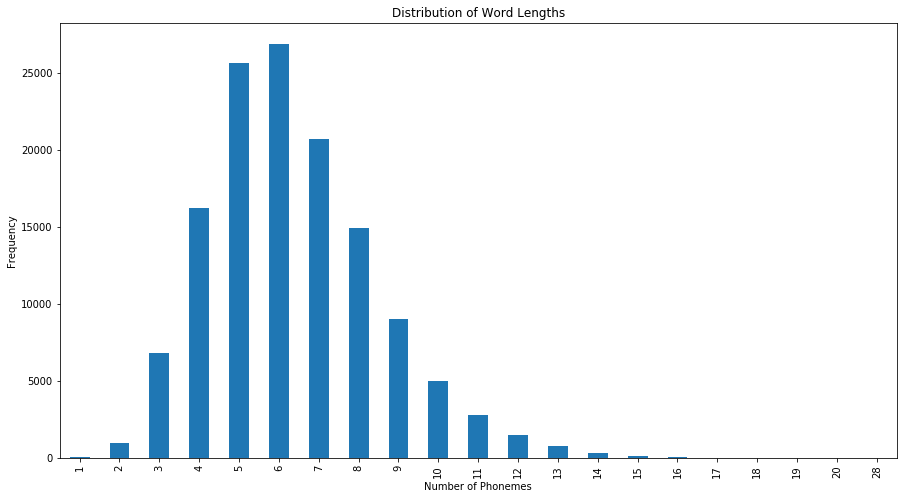

In [9]:
pronunciations.num_phonemes.value_counts().sort_index().plot.bar()
plt.xlabel('Number of Phonemes')
plt.ylabel('Frequency')
_ = plt.title('Distribution of Word Lengths')

Below are the most perplexing words that have at least two syllables.

In [10]:
pronunciations[pronunciations.num_syllables >= 2].sort_values('perplexity', ascending=False).head(20)

,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
ashbaugh,"(ə, ʃ, ˈ, b, ɔ)",əʃˈbɔ,4,2,216.704979
raoux,"(r, æ, ˈ, uː)",ræˈuː,3,2,212.457132
hajdu,"(ˈ, h, ɑː, j, d, uː)",ˈhɑːjduː,5,2,199.125835
ayoub,"(ˈ, eɪ, aʊ, b)",ˈeɪaʊb,3,2,182.251606
ayon,"(eɪ, ˈ, ɔ, n)",eɪˈɔn,3,2,172.335775
saurer,"(ˈ, s, aʊ, ɝ, r)",ˈsaʊɝr,4,2,167.867849
bourgeois,"(b, ʊ, r, ʒ, ˈ, w, ɑː)",bʊrʒˈwɑː,6,2,166.423484
iowa,"(ˈ, aɪ, oʊ, ə)",ˈaɪoʊə,3,3,162.823379
theodorou,"(ˈ, θ, iː, ə, d, ɝ, uː)",ˈθiːədɝuː,6,4,158.815458


Almost all of these words feel somewhat unnatural to me as an English speaker. There are many foreign words, like the french "bourgeois".

Another interesting thing we can look at is which pronunciation the model prefers when a word has multiple standard ones.

In [11]:
display(pronunciations.loc['tomato'])
display(pronunciations.loc['aunt'])
display(pronunciations.loc['nevada'])

,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
tomato,"(t, ə, ˈ, m, ɑː, ˌ, t, oʊ)",təˈmɑːˌtoʊ,6,3,12.841003
tomato,"(t, ə, ˈ, m, eɪ, ˌ, t, oʊ)",təˈmeɪˌtoʊ,6,3,15.208413


,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
aunt,"(ˈ, æ, n, t)",ˈænt,3,1,19.133402
aunt,"(ˈ, ɔ, n, t)",ˈɔnt,3,1,24.126551


,pronunciation,as_string,num_phonemes,num_syllables,perplexity
word,,,,,
nevada,"(n, ə, ˈ, v, ɑː, d, ə)",nəˈvɑːdə,6,3,11.624365
nevada,"(n, ə, ˈ, v, æ, d, ə)",nəˈvædə,6,3,13.972277


The model doesn't have a strong preference between the two pronunciations for "tomato" or "Nevada". But for "aunt", it strongly prefers /ˈænt/. Intuitively this makes sense to me, as /ˈɔnt/ sounds old timey or stilted.

## Can the Model Generate Novel Words? ##
Everyone loves using recurrent neural networks to generate novel sequences! Below I'll generate some words and examine whether the model is doing a good job.

In [12]:
generated_pronunciations = pd.DataFrame({
    'pronunciation': [
        language_model.generate(max_length=1000, temperature=.5)
        for _ in range(10000)
    ]
})

generated_pronunciations['is_novel_word'] = ~generated_pronunciations.pronunciation.isin(pronunciations.pronunciation)
augment_pronunciations_df(generated_pronunciations)

# Occasionally the model generates empty pronunciations.
generated_pronunciations = generated_pronunciations[generated_pronunciations.num_phonemes > 0]

Here are ten novel, generated pronunciations:

In [13]:
generated_pronunciations[generated_pronunciations.is_novel_word == True].sample(10)

,pronunciation,is_novel_word,as_string,num_phonemes,num_syllables
1369,"(ˈ, b, æ, m, ə, n, d)",True,ˈbæmənd,6,2
3315,"(ˈ, s, k, r, ɛ, n, ɝ, ˌ, s, t, r, eɪ)",True,ˈskrɛnɝˌstreɪ,10,3
9834,"(ˈ, m, æ, n, ɝ, ˌ, s, t, iː)",True,ˈmænɝˌstiː,7,3
4665,"(ˈ, ɛ, r, ə, ˌ, p, oʊ)",True,ˈɛrəˌpoʊ,5,3
3044,"(ˈ, s, ɪ, l, t, ɝ, ˌ, eɪ, t, ɝ)",True,ˈsɪltɝˌeɪtɝ,8,4
110,"(ˈ, m, ɑː, r, ə, ˌ, n, aɪ, z)",True,ˈmɑːrəˌnaɪz,7,3
8753,"(ˈ, k, ɛ, l, ɪ, z)",True,ˈkɛlɪz,5,2
8077,"(ˈ, k, r, æ, n, d, ɪ, ŋ)",True,ˈkrændɪŋ,7,2
5480,"(ˈ, b, r, oʊ, f, ɝ)",True,ˈbroʊfɝ,5,2
8013,"(ˈ, d, ɪ, l, iː, ˌ, ɔ, d)",True,ˈdɪliːˌɔd,6,3


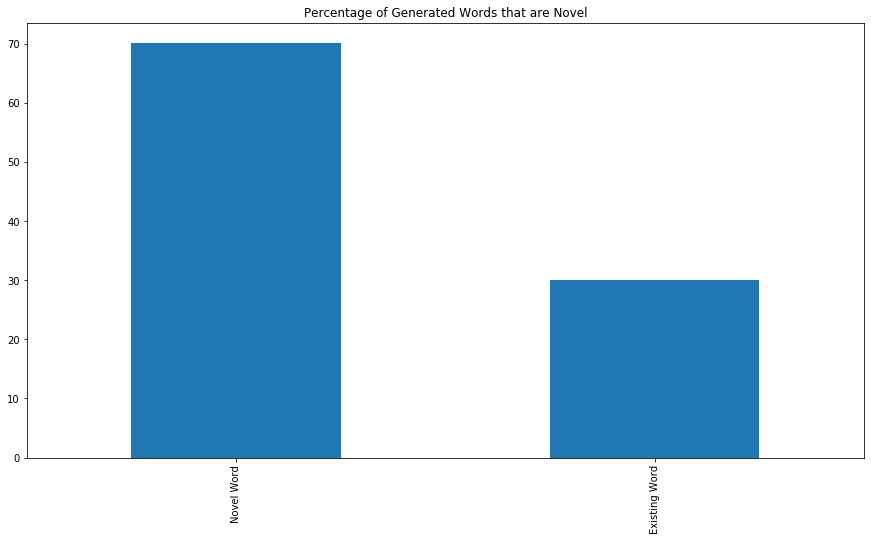

In [14]:
def show_proportion_novel(generated_pronunciations):
    counts = generated_pronunciations.is_novel_word.value_counts()
    percentages = counts / counts.sum() * 100
    
    percentages.index = percentages.index.map({True: 'Novel Word', False: 'Existing Word'})
    percentages.plot.bar()
    plt.title('Percentage of Generated Words that are Novel')

show_proportion_novel(generated_pronunciations)    

Of the 10,000 generated pronunciations about 70% are novel, meaning they didn't occur in the CMU Pronouncing dictionary. The `temperature` argument can alter diversity of the generated pronunciations, with higher temperature resulting in more diversity. Compare the two pronunciations below. The first looks very idiosyncratic whereas the second looks very common.

In [15]:
print(''.join(language_model.generate(max_length=1000, temperature=2)))
print(''.join(language_model.generate(max_length=1000, temperature=1e-5)))

ˈdʒbzwɛtʃməptɑːn
ˈstrændɝ


Here are some of the novel pronunciations. I'm printing five pronunciations for each syllable count.

In [16]:
novel_generated_pronunciations = generated_pronunciations[generated_pronunciations.is_novel_word]

for num_syllables in range(1, 5):
    
    novel_with_syllable_count = novel_generated_pronunciations[novel_generated_pronunciations.num_syllables==num_syllables]
    if novel_with_syllable_count.empty:
        break
    
    print(f'These have {num_syllables} syllables:')

    for pronunciation in novel_with_syllable_count.sample(min(5, len(novel_with_syllable_count))).pronunciation:
        print('\t{}'.format(''.join(pronunciation)))

These have 1 syllables:
	ˈbrɛnd
	ˈʃrɛts
	ˈstrɛmz
	ˈʃænt
	ˈspiːn
These have 2 syllables:
	ˈpoʊlɪs
	ˈlɪkˌfrɛŋ
	ˈskɑːmənd
	ˈtɪdlɪk
	ˈstʌndɝ
These have 3 syllables:
	ˈmænəˌfaɪz
	ˈbɔrtəˌdeɪt
	ˈskændɝnɝ
	ˈstɛlədʒɪz
	ˌɪnˈsɛlə
These have 4 syllables:
	ˈfrɪksəˌleɪtɔɪz
	ˌkɑːləˈmɛlənt
	ˈgɛləˌleɪtɪd
	ˈbriːbɝˌstreɪtɝ
	ˈhɑːrtəˌlɛri


The main thing that jumps out at me is that these all sound like conceivable English words. There are a few sort of awkward words, but there's nothing unpronouncable. And the stress patterns feel natural to me.

I can also compare the distributions of the generated and real pronunciations.

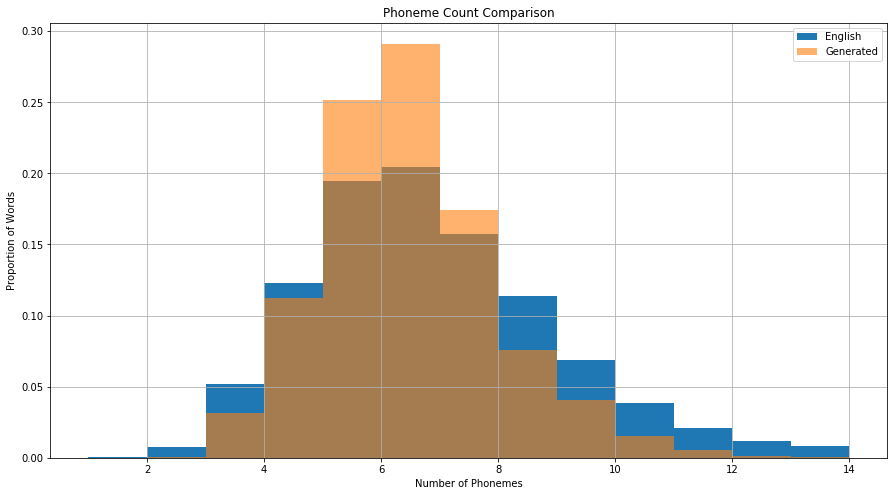

In [17]:
pronunciations.num_phonemes.hist(density=True, bins=np.arange(1, 15), label='English')
generated_pronunciations.num_phonemes.hist(density=True, alpha=.6, bins=np.arange(1, 15), label='Generated')
plt.xlabel('Number of Phonemes')
plt.ylabel('Proportion of Words')
plt.title('Phoneme Count Comparison')
_ = plt.legend()

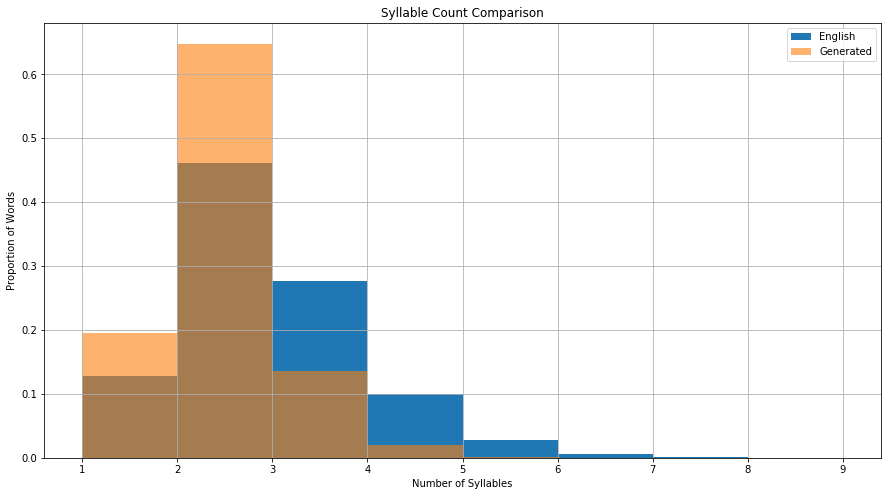

In [18]:
pronunciations.num_syllables.hist(density=True, bins=np.arange(1, 10), label='English')
generated_pronunciations.num_syllables.hist(density=True, alpha=.6, bins=np.arange(1, 10), label='Generated')
plt.xlabel('Number of Syllables')
plt.ylabel('Proportion of Words')
plt.title('Syllable Count Comparison')
_ = plt.legend()

The length of the pronunciations the model generates (both in terms of phonemes and syllables) is similar, but the model has a preference for shorter words. I noticed the more complex models don't have this issue.

## What Rules is the Model Actually Learning? ##

I want to probe the model to make sure it's learning some more general properties. First let's look at the lowest perplexity pronunciation according to the model.

First let's revisit the overfitting example. The plot below shows the probability of each phoneme in the word "installations". So the third bar indicates that the probability of /n/ after seeing /ˌɪ/ is about .6.

In [19]:
print(pronunciations.iloc[0].as_string)

ˌɪnstəˈleɪʃənz


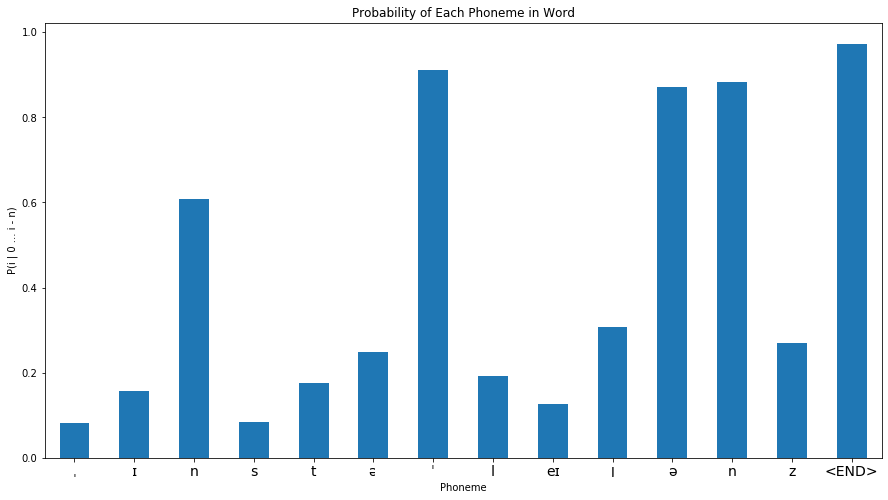

In [20]:
most_likely_pronunciation = pronunciations.iloc[0].pronunciation
plot_pronunciation_probability(language_model, most_likely_pronunciation)

That the model is so certain at times indicates that it memorized sequences of phonemes. I had originally wanted to model possible English pronunciations and had hoped that the predictions following /ˌɪn/ would be more uniform since in reality almost any phoneme can come next. So instead of modeling valid English in a binary way I ended up modeling actual English. I tried even less complex models than this one and found that while they were less opinionated they failed to learn enough to actually generate good pronunciations.

I could further experiment with finding a model that captures *some* English phonotactics rules without getting this specific, but finding that balance is time consuming since there isn't a single numerical metric I can optimize for. And overall, this model is good enough for my purposes.

Now I'll probe what the model knows by examining its predictions. The two plots below are for /ˈseɪ/ and /ˈsɛ/:

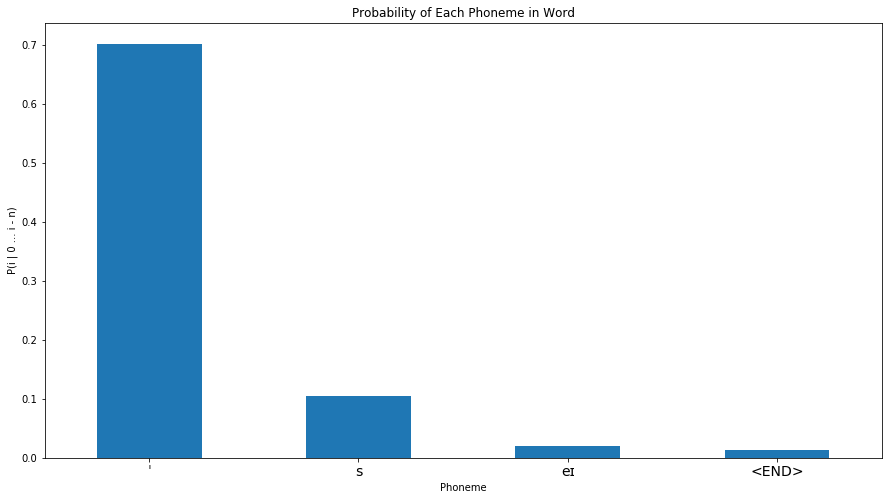

In [21]:
plot_pronunciation_probability(language_model, ("ˈ", "s", "eɪ"))

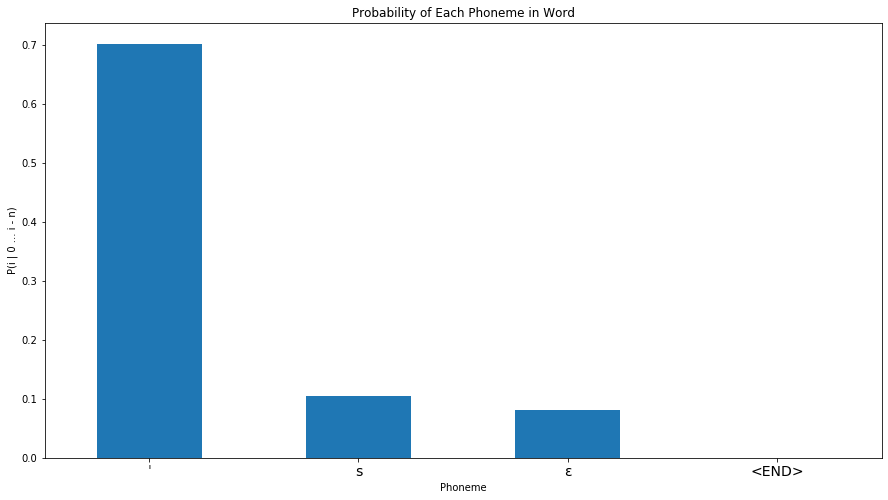

In [22]:
plot_pronunciation_probability(language_model, ("ˈ", "s", "ɛ"))

In the plot for /ˈseɪ/, the model has assigned a probability of `0.02` of the word ending at `\<END>`. In /ˈsɛ/ it has assigned a `0.001` probability of the word ending at `\<END>`. The low probability for /ˈsɛ/ makes sense because in English, if the final syllable is stressed then it should be a strong syllable: it should end in a consonant or a strong vowel. /ɛ/ is a weak vowel while the diphthong /eɪ/ is strong.

Next I'll look at whether the model has learned that /ʌ/ (wedge) and /ə/ (schwa) are basically the same vowel, but /ə/ occurs in unstressed syllables.

The first plot below is the probability of the probability of /ʌ/ and /ə/ occurring after /ˈk/, where the syllable has stress. The second plot is the same but in an unstressed syllable.

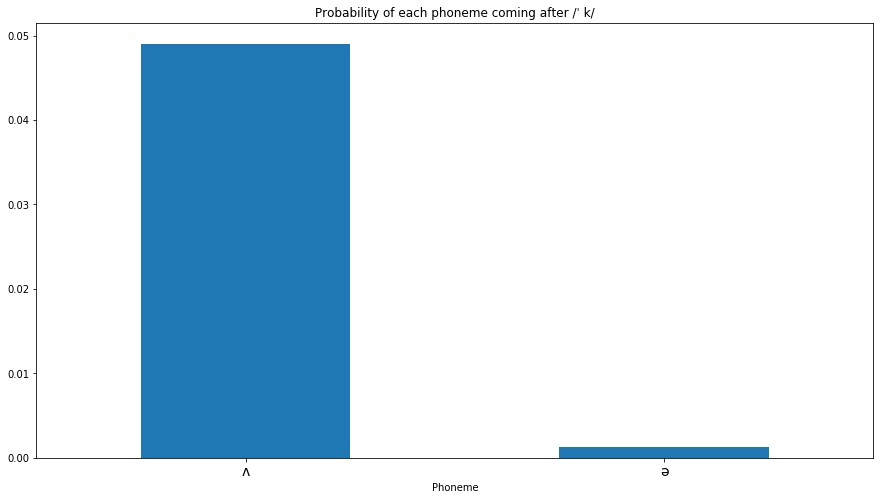

In [23]:
plot_next_phoneme_distribution(language_model, ("ˈ", "k"), phonemes_to_include={"ə", "ʌ"})

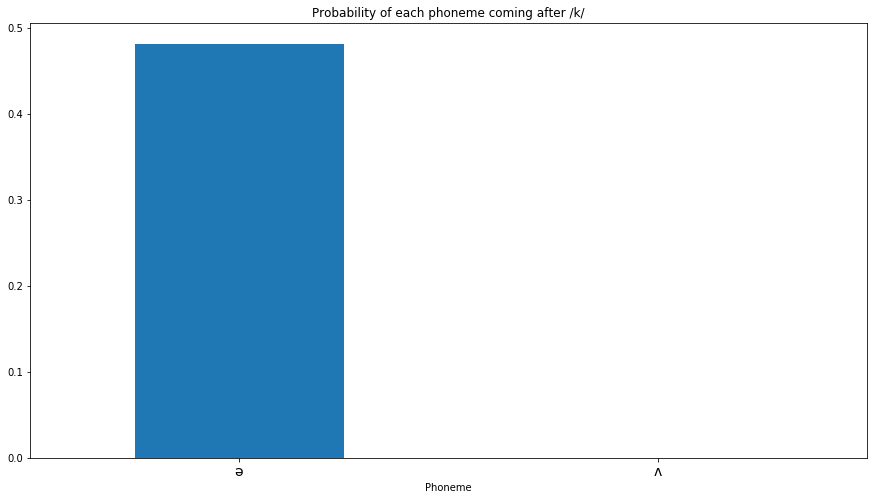

In [24]:
plot_next_phoneme_distribution(language_model, ("k", ), phonemes_to_include={"ə", "ʌ"})

The model has correctly learned when to use /ə/ and /ʌ/.

The model also needs to learn patterns about stress over multiple syllables. A *foot* is a pair of syllables. A *trochee* contains a stressed syllable followed by an unstressed one. And an *iamb* is an unstressed syllable followed by a stressed one.

English, in general, prefers trochees. This implies that the model should assign a lower perplexity to trochees than iambs.

In [25]:
print('Trochee: {:.2f}'.format(language_model.perplexity_of_text(("ˈ", "f", "oʊ", "m", "i"))))
print('Iamb:    {:.2f}'.format(language_model.perplexity_of_text(("f", "oʊ", "ˈ", "m", "i"))))

Trochee: 14.83
Iamb:    63.49


Another English phonotactic rule, from Wikipedia, is: "Two obstruents in the same coda must share voicing (compare kids /K IH1 D Z/ with kits /K IH1 T S/)". Hopefully the model will assign a higher perplexity when this rule is violated below.

In [26]:
print('Perplexity for /ˈtɛgz/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "g", "z"))))
print('Perplexity for /ˈtɛgs/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "g", "s"))))
print()
print('Perplexity for /ˈtɛks/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "k", "s"))))
print('Perplexity for /ˈtɛkz/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "k", "z"))))

Perplexity for /ˈtɛgz/: 14
Perplexity for /ˈtɛgs/: 23

Perplexity for /ˈtɛks/: 9
Perplexity for /ˈtɛkz/: 27


Perplexity is higher when the two phonemes in the coda do not match in voicing. The model could just be learning that adjacent phonemes should ideally share voicing though. To test whether it's actually learned the rule about voicing in codas I'll change the syllable structure.

In [27]:
print('Perplexity for /ˈtɛgzəm/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "g", "z", "ə", "m"))))
print('Perplexity for /ˈtɛgsəm/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "g", "s", "ə", "m"))))
print()
print('Perplexity for /ˈtɛkzəm/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "k", "z", "ə", "m"))))
print('Perplexity for /ˈtɛksəm/: {:.0f}'.format(language_model.perplexity_of_text(("ˈ", "t", "ɛ", "k", "s", "ə", "m"))))

Perplexity for /ˈtɛgzəm/: 18
Perplexity for /ˈtɛgsəm/: 14

Perplexity for /ˈtɛkzəm/: 13
Perplexity for /ˈtɛksəm/: 8


These four words are identical to the first except that I've inserted /əm/ to the end, which allows the /s/ and /z/ to form a second syllable with it. Since /s/ and /z/ become onsets of the next syllable they're not subject to the constraint on the previous syllable's coda.

### Probing the Embeddings ###

I was initially interested in building a language model over IPA pronunciations because I was hoping that the embeddings trained in the embedding layer of the RNN would capture the phonological features of phonemes. For example, the embeddings could capture voicing, place, and manner.

I wasn't able to get this to work in the amount of time I spent training the model. I tried using a very small recurrent layer (e.g 2 to 10 neurons) in hopes that the embeddings would have to capture most of the rules. This did not end up working though, perhaps because with such a small vocabulary the embeddings were able to just reconstruct the actual phonemes.

Below are a few experiments using the embeddings.

In [28]:
print("Most similar to /t/:")
most_similar_phonemes(language_model, language_model.embedding_for('t'))

print()
print("Most similar to /oʊ/:")
most_similar_phonemes(language_model, language_model.embedding_for('oʊ'))

Most similar to /t/:
[1.000]	t
[0.616]	k
[0.616]	θ
[0.407]	p
[0.335]	f
[0.215]	d
[0.181]	ɑː
[0.179]	g
[0.172]	ʃ
[0.145]	i

Most similar to /oʊ/:
[1.000]	oʊ
[0.609]	eɪ
[0.442]	ɝː
[0.427]	iː
[0.406]	ɑː
[0.361]	ə
[0.344]	h
[0.341]	uː
[0.311]	i
[0.259]	ʊ


The embeddings at least appear to capture vowel vs consontant.

Now some analogies:

In [29]:
print("p:b ~ k~?")
analogy(language_model, 'p', 'b', 'k')
print()
print("p:f ~ t~?")
analogy(language_model, 'p', 'f', 't')

p:b ~ k~?
[0.3845] f
[0.2531] w
[0.2244] ə
[0.2088] r
[0.1944] ɔɪ
[0.1774] g
[0.1766] oʊ
[0.1687] j
[0.1655] t
[0.1597] h

p:f ~ t~?
[0.4922] θ
[0.4544] k
[0.2239] ʃ
[0.2125] ɛ
[0.2097] ɑː
[0.2035] r
[0.1617] ʌ
[0.1328] i
[0.1322] j
[0.1232] ə


In the first example, /p/ shares place (bilabial) and manner (stop) with /b/, but /b/ is voiced. So I would expect /p/ to relate to /b/ in the same way that /k/ relates to /g/, since /k/ and /g/ are the same except for voicing. /f/ and /w/ don't really make sense to me.

In the second example, /f/ similar in place and voicing to /p/, but is a fricative instead of a stop. So adding frication to /t/ should give us /s/ but /θ/ also makes sense. /k/ doesn't make sense.



At some point I trained a model with a a large embedding layer and a small hidden RNN dimension (e.g. 3) and the analogies made a little more sense but still were hit or miss. Overall I'm not happy with the quality of the embeddings, but it does appear there is *some* signal here.